In [1]:
import csv
import patsy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import pipeline, feature_selection, model_selection, linear_model, preprocessing
%pylab inline
plt.rcParams['figure.dpi'] = 300
sns.set_style("darkgrid")

C:\Users\Jimmy\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


In [2]:
players = pd.read_csv("output.csv", encoding='latin-1')

In [3]:
players = players[players.Year != "Career Totals"]
players = players[players.GP > 3]
players = players.groupby(["Player", "Year"]).first().reset_index()
players["Player"] = players.Player.str.rstrip()
players.head()

,Player,Year,Position,Club,GP,GS,G,MINS,A,SHTS,SOG,FC,OFF,Y,R
0,A.J. DeLaGarza,2009,Defender,Los Angeles Galaxy,22,21,1,1754,1,3,2,14,0,2,0
1,A.J. DeLaGarza,2010,Defender,Los Angeles Galaxy,17,14,1,1307,0,1,1,14,1,3,0
2,A.J. DeLaGarza,2011,Defender,LA Galaxy,30,30,0,2627,0,3,1,31,1,3,0
3,A.J. DeLaGarza,2012,Defender,LA Galaxy,30,30,0,2644,0,1,0,41,0,4,0
4,A.J. DeLaGarza,2013,Defender,LA Galaxy,28,28,0,2399,0,2,1,22,0,3,0


In [4]:
players_adj = players.copy(deep = True)
players_adj[['G', 'A', 'SHTS', 'SOG', "FC", 'OFF', 'Y', 'R']] = players_adj[['G', 'A', 'SHTS', 'SOG', "FC", 'OFF', 'Y', 'R']].div(players.GP, axis=0)
pd.options.display.float_format = '{:,.4f}'.format

In [5]:
test = players_adj[players_adj.Year == "2018"].select_dtypes(["float64", "int64"])
train = players_adj[players_adj.Year != "2018"].select_dtypes(["float64", "int64"])

In [6]:
params = train.drop(['GP', "GS", "G", "MINS"], 1)
goals = train["G"]
test_params = test.drop(['GP', "GS", "G", "MINS"], 1)
test_goals = test["G"]

In [41]:
select_pipe = pipeline.Pipeline(
    # some features have missing values so this fills in the mean for them
    # this imputer is lazy and often helpful but not always the best option
    [("imp", preprocessing.Imputer()), 
     # scale our features before linear models. it's good data hygiene 
     ("std", preprocessing.StandardScaler()),
     # we'll use select k best to adjust model complexity
     ("select",
      feature_selection.SelectKBest(k = 'all',
          score_func=feature_selection.f_regression)), 
     # our old friend <3
     ("lin", linear_model.LinearRegression())
    ])
select_pipe.fit(params, goals)
select_pipe.score(params, goals)

0.7866998552805723

In [37]:
select_pipe.score(test_params, test_goals)

0.6788486515433392

In [38]:
feat_support = select_pipe.named_steps["select"].get_support()
feat = params.columns[feat_support]
coef = select_pipe.named_steps["lin"].coef_
list(zip(feat, coef))

[('SHTS', -0.01769415761787043),
 ('SOG', 0.13144579422449784),
 ('OFF', 0.01203107018433064)]

In [39]:
cv_result = model_selection.cross_validate(select_pipe, X=params, y=goals, cv=10, return_train_score=True)
print(f"train: {np.mean(cv_result['train_score']):.3}, test: {np.mean(cv_result['test_score']):.3}")

train: 0.786, test: 0.757


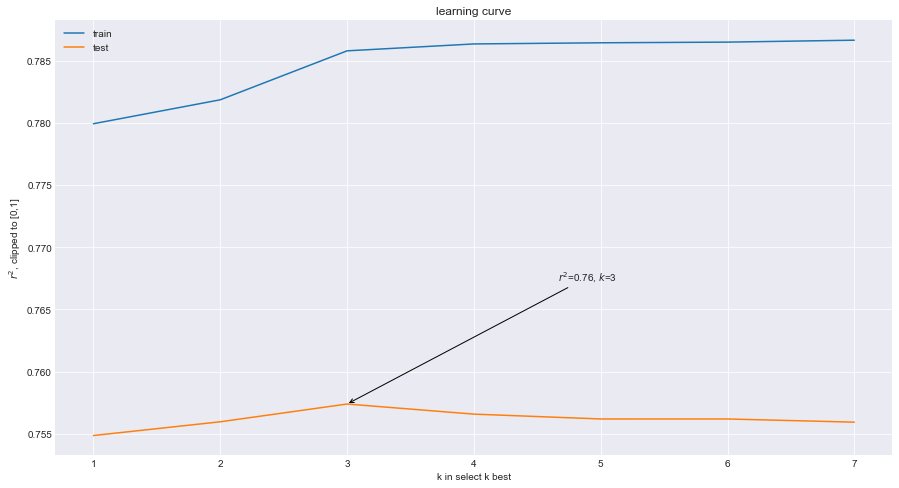

In [40]:
figsize(15, 8)

train_scores = []
test_scores = []
# define feature range
num_feats = len(params.columns)
feat_range = np.arange(num_feats)+1
# for each k in feat_range
for num_f in feat_range:
    # set pipeline params
    select_pipe.set_params(select__k=num_f)
    # get cross val scores
    cv_result = model_selection.cross_validate(
        select_pipe, X=params, y=goals, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))

# plot test vs train
plot(feat_range, train_scores, label="train")
plot(feat_range, test_scores, label="test")

# find index of best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (feat_range[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $k$={feat_range[best_i]}"
annotate(ann_text, xy=ann_xy, xytext=(.6,.4), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )

xlabel("k in select k best")
ylabel("$r^2$, clipped to [0,1]")
title("learning curve")
legend();